### Градиентный бустинг "в лоб"

In [39]:
import pandas as pd
features = pd.read_csv('features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [40]:
features.drop(['duration', 'barracks_status_dire', 'barracks_status_radiant',
    'tower_status_dire', 'tower_status_radiant'], axis=1, inplace=True)

###### Проверка на наличие пропусков

In [3]:
spaces = len(features) - features.count()
spaces[spaces > 0].sort_values(ascending=False)/len(features)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

#### Обоснование:  
- first_blood_player2 - первое убийство в 45% случаев совершается одним игроком
- first_blood_time - кровь отсутствует в 20% случаев в первые 5 минут игры.

###### Замена пропусков на нули

In [41]:
features.fillna(0, inplace=True)

Целевую переменную содержит столбец **radiant_win**.

In [42]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import datetime as dt

X_train = features.drop('radiant_win', axis=1)
y_train = features['radiant_win']

cv = KFold(n_splits=5, shuffle=True, random_state = 21)

Число деревьев = 10
Score = 0.664
Время: 0:00:15.157414

Число деревьев = 20
Score = 0.683
Время: 0:00:30.789321

Число деревьев = 30
Score = 0.690
Время: 0:00:46.100474

Число деревьев = 40
Score = 0.694
Время: 0:01:00.314606

Число деревьев = 50
Score = 0.697
Время: 0:01:15.948650



<AxesSubplot:>

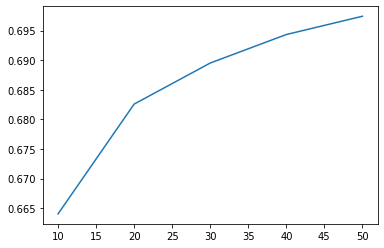

In [6]:
scores = {}
for n in [10, 20, 30, 40, 50]:
    gb = GradientBoostingClassifier(n_estimators = n, random_state = 21)
    start = dt.datetime.now()
    score = cross_val_score(gb, X_train, y_train, cv = cv, scoring='roc_auc', n_jobs = -1).mean()
    scores[n] = score
    print(f'Число деревьев = {n}')
    print(f'Score = {score:.3f}')
    print(f'Время: {dt.datetime.now() - start}')      
    print()   
          
pd.Series(scores).plot()

Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 46.1 сек. Метрика качества AUC-ROC равна 0.69.  
Для увеличения качества имеет смысл использовать больше деревьев, так как оно возрастает с увеличением их числа. Чтобы ускорить обучение, нужно уменьшить параметр max_depth - максимальную глубину дерева.

### Логистическая регрессия

In [43]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), 
        index=X_train.index, columns=X_train.columns)
X_train

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,...,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,...,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,...,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,...,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.562864,-0.551154,-0.970428,0.837439
4,-2.529221,1.540688,-1.182811,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,...,-0.987486,1.347455,1.024223,-0.022021,0.680811,1.590976,-0.302485,0.678170,-0.970428,-0.228816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1.093978,-0.575157,-0.138714,0.501314,0.834109,0.107949,0.637942,-0.537757,1.017574,-0.108632,...,-0.987486,-0.568506,0.997237,0.218879,0.228972,0.018054,0.562864,0.678170,-0.970428,-0.427189
114403,1.096181,-0.927798,-0.261549,0.501314,0.987660,0.577666,0.637942,-0.537757,1.017574,-1.309804,...,-0.987486,0.044601,-1.431548,-0.142472,-1.578386,0.542361,-0.302485,-0.551154,-0.970428,-0.253612
114404,1.098746,-0.575157,1.427430,0.501314,0.292267,-1.309820,-1.131661,-0.537757,-0.578083,-1.309804,...,1.769891,-0.645145,1.928271,0.580230,-1.578386,-1.030561,-2.033183,0.678170,0.437788,-0.204019


In [44]:
from sklearn.linear_model import LogisticRegression
def logit(X, y):
    scores = {}
    for n in range(-3, 4):
        C = 10 ** n
        log = LogisticRegression(C = C, random_state = 21)
        score = cross_val_score(log, X_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1).mean()
        scores[n] = score
        print(f'C = {C}')
        print(f'Score = {score:.3f}')    
        print()
    return pd.Series(scores)

C = 0.001
Score = 0.716

C = 0.01
Score = 0.716

C = 0.1
Score = 0.716

C = 1
Score = 0.716

C = 10
Score = 0.716

C = 100
Score = 0.716

C = 1000
Score = 0.716



<AxesSubplot:>

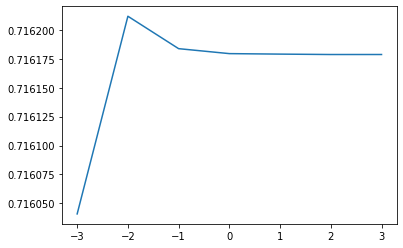

In [45]:
scores = logit(X_train, y_train)
scores.plot()

In [46]:
best = pd.Series(scores).sort_values(ascending=False).head(1)
print(f'Наилучшее значение показателя AUC-ROC достигается при C = \
{10.0 ** best.index[0]:.3f} и равно {best.values[0]:.3f}.')

Наилучшее значение показателя AUC-ROC достигается при C = 0.010 и равно 0.716.


Логистическая регрессия работает намного быстрее градиентного бустинга над случайным лесом и показывает при этом более высокое качество (**0.716** в сравнении с **0.69**).

In [33]:
heros = [f'r{i}_hero' for i in range (1, 6)] + [f'd{i}_hero' for i in range (1, 6)]
cat = ['lobby_type'] + heros
X_train.drop(cat, axis=1, inplace=True)

C = 0.001
Score = 0.716

C = 0.01
Score = 0.716

C = 0.1
Score = 0.716

C = 1
Score = 0.716

C = 10
Score = 0.716

C = 100
Score = 0.716

C = 1000
Score = 0.716



<AxesSubplot:>

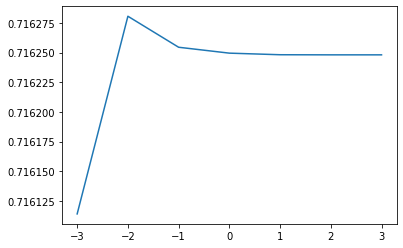

In [34]:
scores = logit(X_train, y_train)
scores.plot()

После удаления категориальных признаков показатель качества остался равным **0.716**. Следовательно, эти признаки никак не влияют на результат работы модели.

In [36]:
import numpy as np
heroes = np.unique(features[heros].values.ravel())
print(f'Уникальных героев - {len(heroes)}.')

Уникальных героев - 108.


##### Мешок слов:

In [37]:
def bag(features):
    X = np.zeros((features.shape[0], max(heroes)))
    for i, match_id in enumerate(features.index):
        for j in range(1, 6):
            X[i, features.loc[match_id, f'r{j}_hero'] - 1] = 1
            X[i, features.loc[match_id, f'd{j}_hero'] - 1] = -1
        
    return pd.DataFrame(X, index = features.index, columns=[f'hero_{i}' for i in range(max(heroes))])

X_train = pd.concat([X_train, bag(features)], axis=1)
X_train.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.529221,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-1.243393,-1.008757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C = 0.001
Score = 0.746

C = 0.01
Score = 0.751

C = 0.1
Score = 0.752

C = 1
Score = 0.752

C = 10
Score = 0.752

C = 100
Score = 0.752

C = 1000
Score = 0.752



<AxesSubplot:>

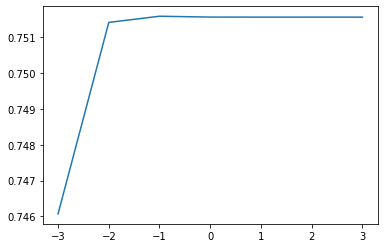

In [38]:
scores = logit(X_train, y_train)
scores.plot()

При добавлении "мешка слов" качество значительно увеличилось (**0.752** в сравнении с **0.716**). Это происходит потому, что множество признаков, которые были бессмысленным шумом, теперь оказывают положительное влияние на результат работы модели.

In [18]:
log = LogisticRegression(C = 0.01, random_state = 21)
log.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=21)

In [9]:
test = pd.read_csv('features_test.csv')
test.fillna(0, inplace=True)
X_test = pd.DataFrame(sc.fit_transform(test), index = test.index, 
                      columns = test.columns)
X_test.drop(cat, axis = 1, inplace = True)
X_test = pd.concat([X_test, bag(test)], axis = 1)
X_test.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
0,-1.729109,-2.514875,0.474746,-0.237743,-0.137094,-0.370005,-0.532732,1.003884,0.305165,-0.368985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.729078,-2.513895,-1.365630,-1.207913,-1.255660,-1.145090,-0.532732,-0.593200,0.305165,0.567766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.728988,-2.512377,-1.365630,-0.862057,-0.742715,-1.145090,-0.532732,-0.593200,1.898546,-1.305736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.728897,-2.508381,-0.445442,-0.938323,-0.537967,-1.145090,0.968865,1.003884,1.101855,-1.305736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
4,-1.728807,-2.507087,0.474746,0.038942,-1.059534,-0.812911,-0.532732,-0.593200,0.305165,1.504517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


count    17177.000000
mean         0.519575
std          0.188267
min          0.016154
25%          0.378973
50%          0.523777
75%          0.661593
max          0.985542
dtype: float64

<AxesSubplot:>

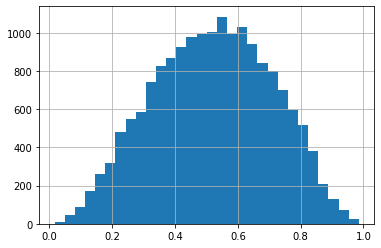

In [19]:
predictions = pd.Series(log.predict_proba(X_test)[:, 1])
display(predictions.describe())
predictions.hist(bins=30)

Минимальное значение прогноза логистической регрессии на тестовой выборке - **0.016**, максимальное значение - **0.986**.